measure correlation of gene expressions by:
1. comparing differential genes between heart & FL in mouse & chicken
2. correlate gene expressions with matched control similar to Berthelot et al 2017

# Setup

In [ ]:
libs <- c("here", "tidyverse",
          "rtracklayer", "biomaRt", "GenomicFeatures", "clusterProfiler", "SummarizedExperiment", "ensembldb", "tictoc")
invisible(suppressMessages(lapply(libs, library, character.only = TRUE)))

source(here('code', 'utils.R'))

theme_set(theme_bw(base_size = 20, base_family="Helvetica"))
theme_update(panel.grid.minor = element_blank(),
             panel.spacing = unit(1.5, "lines"),
             panel.border = element_blank(),
             axis.line = element_line(),
             plot.margin = margin(2, 2, 2, 2, unit = "lines"),
             panel.grid.major = element_blank(), 
             axis.ticks = element_line(),
             strip.background = element_blank(), 
             legend.title = element_blank())

-----

# Functions

In [4]:
getCounts <- function(path){
   df <- data.table::fread(path, select=c(1,2), skip = 4)
   counts <- df$V2
    names(counts) <- df$V1
   return(counts)
}

----

# Differential analysis

load in raw counts & run DE analysis

In [5]:
rnadir <- '/project/ibr_procs/data/_processing/rna/_bam'

build SE from STAR gene counts as input for DESeq2

In [ ]:
mmus.files <- list.files(rnadir, pattern = glob2rx('RNA*E*5*.ReadsPerGene.out.tab'),
                         full.names = T) %>% setNames(gsub('.ReadsPerGene.out.tab', '', basename(.)))

ggal.files <- list.files(rnadir, pattern = glob2rx('RNA*HH*.ReadsPerGene.out.tab'), 
                         full.names = T) %>% setNames(gsub('.ReadsPerGene.out.tab', '', basename(.)))

mmus.mat <- do.call('cbind', lapply(mmus.files, function(path) getCounts(path)))
ggal.mat <- do.call('cbind', lapply(ggal.files, function(path) getCounts(path)))            

#- build custom SE to store counts
ggal.se <- SummarizedExperiment(assays = list(counts = ggal.mat), 
                                colData = DataFrame(row.names = colnames(ggal.mat),
                                                   stage = str_extract(colnames(ggal.mat), 'HH[:digit:]{2}'),
                                                   rep = sub('.*Rep', 'Rep', colnames(ggal.mat)), 
                                                   tissue = str_extract(colnames(ggal.mat), 'heart|FL')))


mmus.se <- SummarizedExperiment(assays = list(counts = mmus.mat), 
                                colData = DataFrame(row.names = colnames(mmus.mat),
                                                   stage = str_extract(colnames(mmus.mat), 'E[:digit:]{3}'),
                                                   rep = sub('.*Rep', 'Rep',colnames(mmus.mat)), 
                                                   tissue = str_extract(colnames(mmus.mat), 'heart|FL')))


Warning message in DESeqDataSet(mmus.se, design = ~rep + tissue + stage):
"some variables in design formula are characters, converting to factors"
Warning message in DESeqDataSet(ggal.se, design = ~rep + tissue + stage):
"some variables in design formula are characters, converting to factors"
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [ ]:

library(DESeq2)

#DEseq dataset
DEds.list <- list(mmus = DESeqDataSet(mmus.se, design = ~rep + tissue + stage), 
                  ggal = DESeqDataSet(ggal.se, design = ~rep + tissue + stage))

#set factor level
DEds.list <- lapply(DEds.list, function(ds){
    ds$tissue <- relevel(ds$tissue, ref = 'FL')
    return(ds)
})

## Run DE analysis

DE.list <- lapply(DEds.list, function(ds) DESeq(ds))

# Get Gene Lists with annotated orthology

In [7]:
GRCg7b <- useEnsembl(biomart = "genes", dataset = 'ggallus_gene_ensembl')
GRCm39 <-  useEnsembl(biomart = "genes", dataset = "mmusculus_gene_ensembl")

Ensembl site unresponsive, trying useast mirror



In [17]:
## Ortho query from web server for mouse->chicken orthologous genes
bmOG <- suppressMessages(read_tsv(here("data", "references", "biomart_mouse-chicken_orthogenes.tsv")))
    colnames(bmOG) <- gsub(pattern = "\\s", "_", colnames(bmOG))
    colnames(bmOG)[-4][4] <- 'GOC_score'


## get chicken anno + for duplicated annotation, get the one with the highest GOC score
bmOG <- aggregate(GOC_score~Chicken_gene_stable_ID + Chicken_homology_type +Gene_stable_ID, bmOG, max) %>% 
    dplyr::select(ggal_geneid = Chicken_gene_stable_ID, 
                  homology_type = Chicken_homology_type, 
                  mmus_geneid = Gene_stable_ID)

get lists of 1:1 OGs

In [18]:
mmus.ogs <- bmOG[bmOG$homology_type=='ortholog_one2one', 'mmus_geneid']
ggal.ogs <- bmOG[bmOG$homology_type=='ortholog_one2one', 'ggal_geneid']

In [ ]:
factor(bmOG$homology_type)

In [19]:
resLFC.list <- lapply(DE.list, function(ds){
    res <- lfcShrink(ds, coef = "tissue_heart_vs_FL")
    return(res)
})

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



In [20]:
mmus.df_tissue <- data.frame(resLFC.list[[1]]) %>% 
mutate(mmus_geneid = gsub("\\.[0-9]+$", "", rownames(.)))

ggal.df_tissue <- data.frame(resLFC.list[[2]]) %>% 
mutate(ggal_geneid = rownames(.)) 

In [12]:
head(mmus.df_tissue)

,baseMean,log2FoldChange,lfcSE,pvalue,padj,mmus_geneid
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSMUSG00000102693.2,0.000000,NA,NA,NA,NA,ENSMUSG00000102693
ENSMUSG00000064842.3,0.000000,NA,NA,NA,NA,ENSMUSG00000064842
ENSMUSG00000051951.6,13.363943,0.8056924,0.5433578,0.083806952,0.129741631,ENSMUSG00000051951
ENSMUSG00000102851.2,0.000000,NA,NA,NA,NA,ENSMUSG00000102851
ENSMUSG00000103377.2,2.223493,0.8913395,1.5094392,0.068844573,0.109340686,ENSMUSG00000103377
ENSMUSG00000104017.2,3.105606,4.9011671,2.9187499,0.001894208,0.004213641,ENSMUSG00000104017


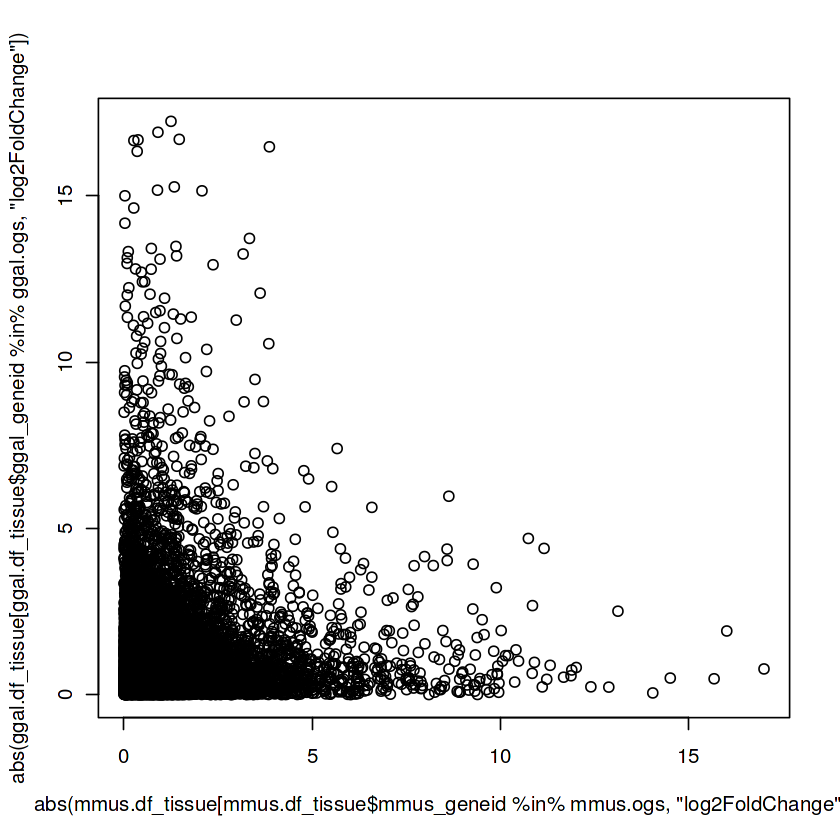

In [106]:
plot(abs(mmus.df_tissue[mmus.df_tissue$mmus_geneid %in% mmus.ogs, 'log2FoldChange']), 
    abs(ggal.df_tissue[ggal.df_tissue$ggal_geneid %in% ggal.ogs, 'log2FoldChange']))

In [21]:
mmus_tissue <- bmOG %>% 
left_join(dplyr::select(mmus.df_tissue, log2FoldChange, padj, mmus_geneid), by='mmus_geneid') %>%
mutate(sp = 'mmus') 
ggal_tissue <- bmOG %>% 
left_join(dplyr::select(ggal.df_tissue, log2FoldChange, padj, ggal_geneid), by='ggal_geneid') %>% 
mutate(sp = 'ggal')

l2fc_tissue.df <- rbind(mmus_tissue, ggal_tissue)

In [22]:
bmOG.l2fc_HtvsFL <- bmOG %>% 
left_join(dplyr::select(mmus.df_tissue, log2FoldChange, padj, mmus_geneid), by='mmus_geneid') %>% 
left_join(dplyr::select(ggal.df_tissue, log2FoldChange, padj, ggal_geneid), 
          by='ggal_geneid', 
          suffix =c('.mmus', '.ggal')) 

In [23]:
head(bmOG.l2fc_HtvsFL)

,ggal_geneid,homology_type,mmus_geneid,log2FoldChange.mmus,padj.mmus,log2FoldChange.ggal,padj.ggal
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSGALG00010027722,ortholog_one2one,ENSMUSG00000000001,-0.5841165,1.240918e-09,-0.7521652,4.042293e-46
2,ENSGALG00010028912,ortholog_one2many,ENSMUSG00000000003,NA,NA,1.2613309,1.606526e-05
3,ENSGALG00010024480,ortholog_one2one,ENSMUSG00000000028,-0.3773817,6.951907e-05,-0.6858150,6.523205e-21
4,ENSGALG00010002345,ortholog_one2one,ENSMUSG00000000037,-0.3407380,8.315557e-02,-1.5489293,2.533468e-86
5,ENSGALG00010029213,ortholog_one2one,ENSMUSG00000000049,1.0598371,4.838196e-02,2.1346141,7.342159e-03
6,ENSGALG00010029150,ortholog_one2one,ENSMUSG00000000056,0.1850654,1.970258e-01,0.4184737,6.804877e-06


In [50]:
bmOG.l2fc_HtvsFL <- bmOG.l2fc_HtvsFL %>% 
dplyr::filter(homology_type == 'ortholog_one2one') %>% 
drop_na(starts_with('padj')) %>% 
dplyr::filter(padj.mmus <= 0.05 | padj.ggal <= 0.05) %>% 
mutate(deg.set = case_when(log2FoldChange.mmus > 1 & log2FoldChange.ggal > 1 ~ 'deg1', 
                           log2FoldChange.mmus > 1 & log2FoldChange.ggal < -1 ~ 'deg2', 
                           log2FoldChange.mmus < -1 & log2FoldChange.ggal < -1 ~ 'deg3', 
                           log2FoldChange.mmus < -1 & log2FoldChange.ggal > 1 ~ 'deg4', 
                           TRUE ~ 'non-deg'))

In [115]:
bmOG.l2fc_HtvsFL$mgi_symbol <- getBM(mart = GRCm39, 
                                values=bmOG.l2fc_HtvsFL$mmus_geneid,
                                filters = 'ensembl_gene_id',
                                attributes = c('mgi_symbol', 'ensembl_gene_id'))$mgi_symbol


Batch submitting query [=========>---------------------]  33% eta:  2s

Batch submitting query [====================>----------]  67% eta:  1s
                                                                      



In [129]:


labs <- c('Hoxd13', 'Grem1', 'Gli1', 'Hoxa11',
          'Hand2', 'Tbx5',
          'Nkx2-5', 'Tbx20', 'Pakap',  'Gata4', 'Isl1', 'Mef2c', 'Myh7')
bmOG.l2fc_HtvsFL <- bmOG.l2fc_HtvsFL %>% 
    mutate(gene_labs=ifelse(mgi_symbol %in% labs, mgi_symbol, ''))

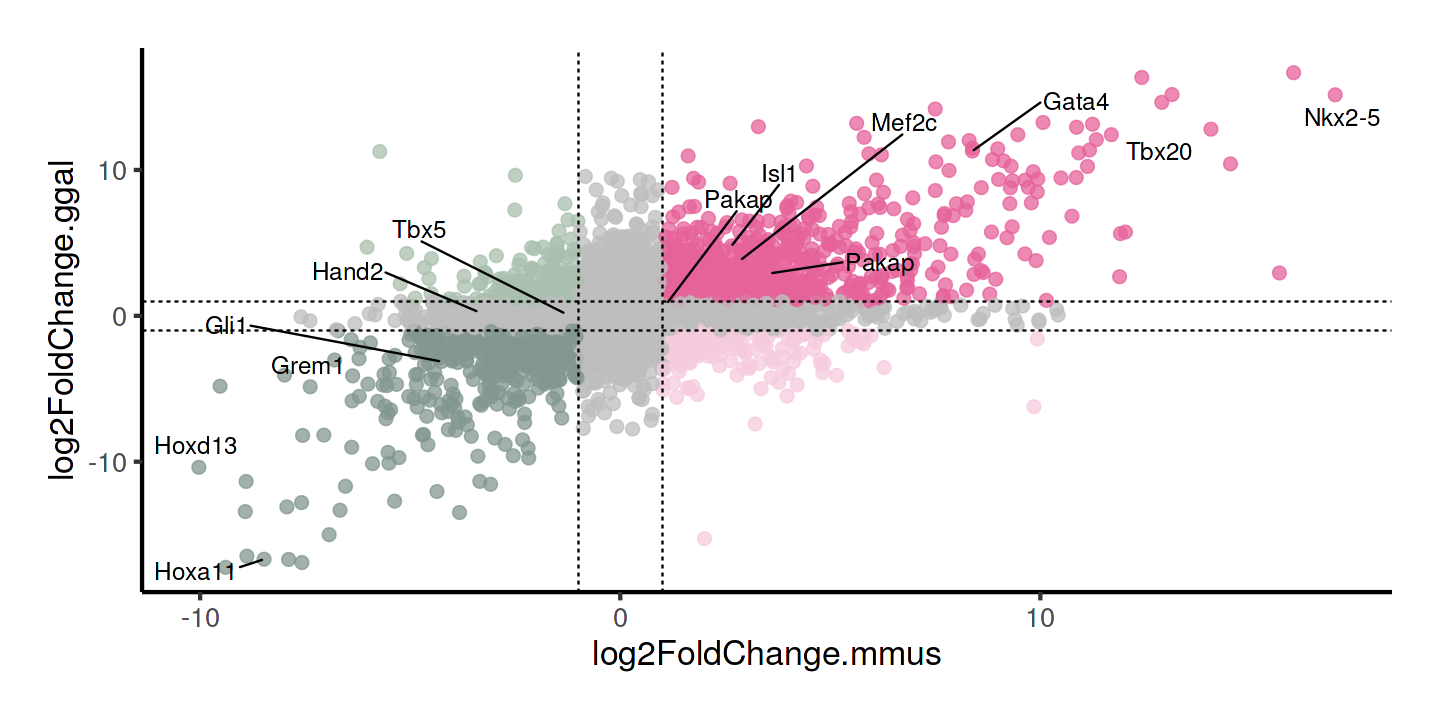

In [134]:
deg.set_cols <- c('#E56399', '#F6CBDD', '#839791', '#AAC0AF', 'grey')
#deg.set_cols <- c('#a24465', '#ca819b', '#3083e8', '#d1e3fa','#ffcc00', '#fff0b3', 'grey')
fig1b.1 <- bmOG.l2fc_HtvsFL %>%
ggplot(aes(x=log2FoldChange.mmus, y=log2FoldChange.ggal)) +
geom_point(aes(color = deg.set), 
           size = 5, alpha = .75, shape = 20) +
geom_text_repel(aes(label=gene_labs), 
                box.padding=0.5, size = 5, max.overlaps=Inf) +
geom_hline(yintercept = c(-1, 1), linetype = 'dashed', color = 'black') +
geom_vline(xintercept = c(-1, 1), linetype = 'dashed', color = 'black') +
scale_color_manual(values = deg.set_cols) +
theme(legend.position='none')

fig1b.1 

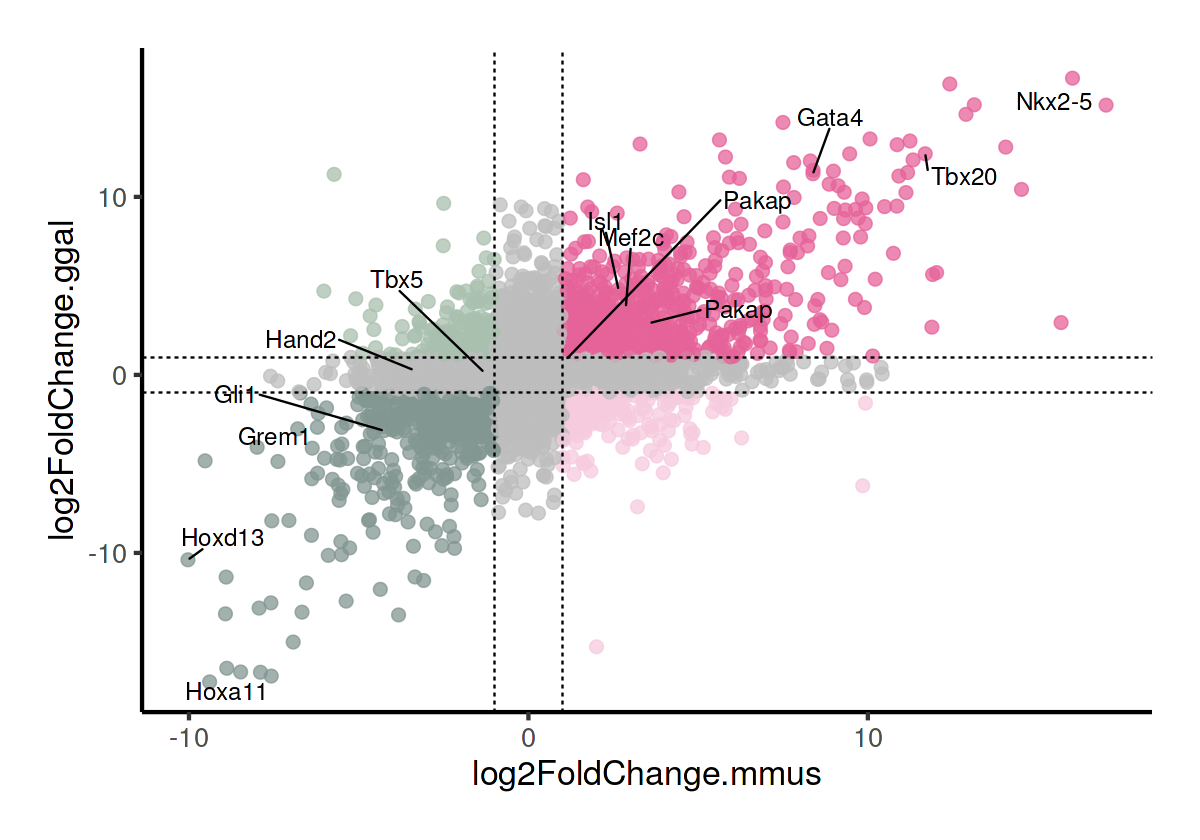

In [141]:
set_plot_dimensions(10, 7)
fig1b.1

## GO annotations

In [ ]:
library(org.Mm.eg.db)

In [73]:
getEntrezBM <- function(ensemble_ids, mart){
      out <- getBM(mart = GRCm39, 
            values=ensemble_ids,
            filters = 'ensembl_gene_id',
            attributes = c('entrezgene_id', 'ensembl_gene_id'))$entrezgene_id
    return(out)
}

engo.wrapper <- function(genes, gene.universe, mart,
                         is.Entrez = FALSE,
                         max.pval = 0.05) {
    
    ## wrapper to convert list of ens ID adn filter GO output
    if (!is.Entrez) {
        entrez <- getEntrezBM(ensemble_ids = genes, mart=mart)
    } else entrez <- genes
    
    engo <- enrichGO(gene = entrez, 
                     OrgDb = org.Mm.eg.db, 
                     universe = gene.universe,
                     pAdjustMethod = "BH",
                     pvalueCutoff  = max.pval,
                     minGSSize = 100, 
                     ont = 'BP', 
                     readable = TRUE)
    out <- data.frame(engo)
    if (nrow(out)!= 0) {
        out <- out %>% group_by(geneID) %>% summarise_all(min) %>% 
        arrange(p.adjust) %>% 
        mutate(padj = -log10(p.adjust))
        return(out)
    }    
}

filter out low-count genes and keep the rest of (mouse) genes as background (n=23225)

In [57]:
keep <- rowSums(counts(DEds.list$mmus) >= 10)
#length(rownames(DEds.list$mmus[keep, ])) #23225

bgentrez <- getEntrezBM(ensemble_ids = rownames(DEds.list$mmus[keep, ]), 
                        mart = GRCm39)


Batch submitting query [=====>-------------------------]  20% eta:  9s

Batch submitting query [===========>-------------------]  40% eta:  9s

Batch submitting query [==================>------------]  60% eta:  5s

Batch submitting query [========================>------]  80% eta:  2s
                                                                      



In [61]:
degs <- sapply(levels(factor(bmOG.l2fc_HtvsFL$deg.set))[-5], function(set){
    bmOG.l2fc_HtvsFL[bmOG.l2fc_HtvsFL$deg.set== set, ]$mmus_geneid
})

In [72]:
head(degs[['deg1']])

[1] "ENSMUSG00000000049" "ENSMUSG00000000078" "ENSMUSG00000000214"
[4] "ENSMUSG00000000244" "ENSMUSG00000000253" "ENSMUSG00000000266"

In [75]:
tic()
engo_all <- lapply(names(degs), function(set){
        df <- engo.wrapper(genes = degs[[set]], 
                           gene.universe = bgentrez, max.pval = 0.05)
        if (!is.null(df)) {
            df$set <- set
            return(df)
        }
    })
toc()

`universe` is not in character and will be ignored...

`universe` is not in character and will be ignored...

`universe` is not in character and will be ignored...

`universe` is not in character and will be ignored...



106.154 sec elapsed


In [88]:
## manual selection of relevant GO terms

engo_filt <- rbind(dplyr::filter(engo_all[[1]], ID %in% c('GO:0003012', 'GO:0048738', 'GO:0042391')), 
                   dplyr::filter(engo_all[[2]], ID %in% c('GO:0007188', 'GO:0060249')), 
                   dplyr::filter(engo_all[[3]], ID %in% c('GO:0007389', 'GO:0048705', 'GO:0048736')), 
                   dplyr::filter(engo_all[[4]], ID %in% c('GO:0050890', 'GO:0007626')))


In [96]:
engo_filt$set <- factor(engo_filt$set, 
                        levels = c('deg1', 'deg2', 'deg3', 'deg4'))


engo_filt$Description <- factor(engo_filt$Description, 
       levels = unique(engo_filt$Description[order(engo_filt$set)]))

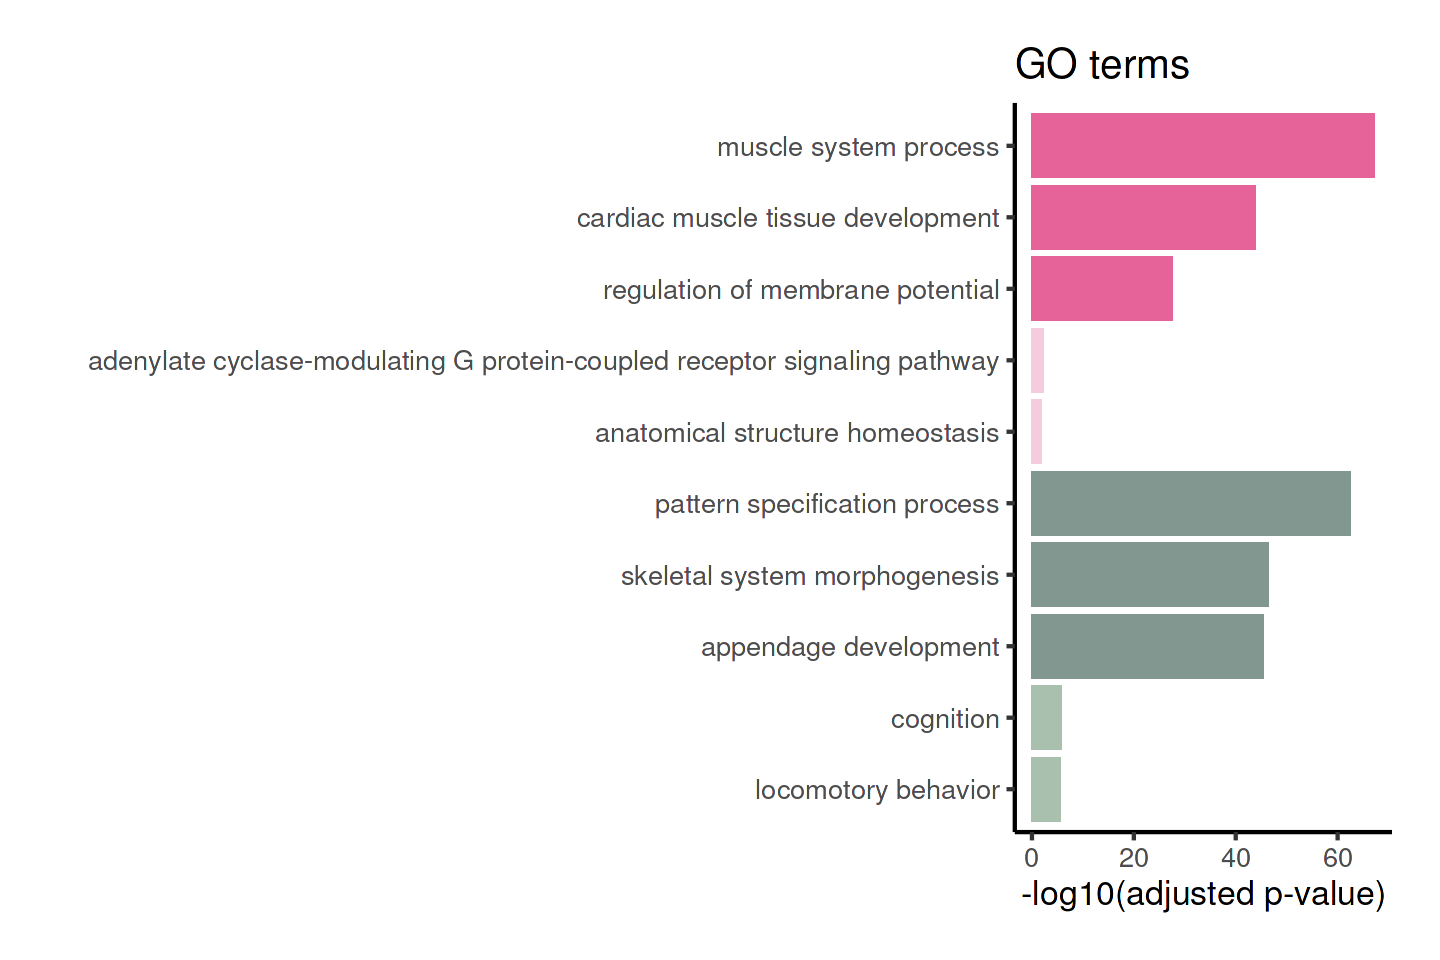

In [138]:
set_plot_dimensions(12, 8)

fig1b.2 <- engo_filt %>% 
ggplot(aes(x = fct_rev(Description), y = padj, fill = set)) +
geom_col()+
labs(x = '', y = '-log10(adjusted p-value)') +
coord_flip() +
scale_fill_manual(values=deg.set_cols[1:4])+
theme(legend.position = 'none') +
labs(title = 'GO terms')

fig1b.2 

In [139]:
pdf(here('figures', 'fig1b_L2FC_HeartvsLimb_2.pdf'), width = 12, height = 6)
fig1b.2
dev.off()

png 
  2

In [133]:
head(engo_all[[2]])

geneID,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,Count,padj,set
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>
Gcg/Akap5/Calcr/P2ry1/Npy2r/Adrb3/Npb/Adra2c/Pthlh/Oprd1/Adra2b,GO:0007188,adenylate cyclase-modulating G protein-coupled receptor signaling pathway,11/242,227/28814,3.844608e-06,0.004632752,0.003824373,11,2.334161,deg2
Cltrn/Grm2/Syt4/P2ry1/Npy2r/Syt8/Syt12,GO:0015837,amine transport,7/242,116/28814,5.793470e-05,0.014322373,0.011823230,7,1.843985,deg2
Csf1/Homer2/Mstn/P2ry1/Ctsk/Cd38/Tpp1/Enpp1/Mbp/Pthlh/Kcnh1,GO:0060249,anatomical structure homeostasis,11/242,328/28814,1.135656e-04,0.014322373,0.011823230,11,1.843985,deg2
Gcg/Cltrn/Akap5/Calcr/Syt4/P2ry1/Npy2r/Mif/Kcnc2/Scn3b/Kcne1l,GO:0043270,positive regulation of ion transport,11/242,329/28814,1.166384e-04,0.014322373,0.011823230,11,1.843985,deg2
P2ry1/Npy2r/Npy/Adrb3/Gdf15/Npb/Oprd1,GO:0007631,feeding behavior,7/242,130/28814,1.188579e-04,0.014322373,0.011823230,7,1.843985,deg2
Pmel/Pnkd/Ctsk/Npy/Slco1c1/Gch1/Foxe1,GO:0018958,phenol-containing compound metabolic process,7/242,126/28814,9.772751e-05,0.014322373,0.011823230,7,1.843985,deg2


In [63]:
getEntrezBM(head(degs[[1]]), mart = GRCm39)

[1] 11818 23849 21823 27027 66355 23947